In [1]:
from scipy import misc, ndimage, signal
from sklearn.model_selection  import train_test_split
import numpy
import numpy as np
import random
import ntpath
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from tensorflow.keras import optimizers 
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras import backend as K
from time import time
import time as tm
import datetime
from operator import itemgetter
import glob
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.utils
from numpy import argmax
import seaborn as sn 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# para compatibilidad con la RTX 2080 super
# esto no es necesario para la RTX 2080 ti
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
T3 = 3;
def Tanh3(x):
    tanh3 = K.tanh(x)*T3
    return tanh3

In [3]:
X = np.load('../InpactorDB/InpactorDB_v1.fasta.filtered.npy')
Y = np.load('../InpactorDB/InpactorDB_v1.fasta.filtered_lables.npy')

#X = np.load('../InpactorDB/repbase_LTRs_I_3dom.fasta.lineages_final.filtered.npy')
#Y = np.load('../InpactorDB/repbase_LTRs_I_3dom.fasta.lineages_final.filtered_lables.npy')


# using InpactorDB splitted into training (PGSB, Repbase, RepetDB) and dev_test (LTR_STRUC)
#X_train = np.load('../InpactorDB/InpactorDB_training.fasta.filtered.npy')
#Y_train = np.load('../InpactorDB/InpactorDB_training.fasta.filtered_lables.npy')

#X_test_dev = np.load('../InpactorDB/InpactorDB_LTR_STRUCT.fasta.filtered.npy')
#Y_test_dev = np.load('../InpactorDB/InpactorDB_LTR_STRUCT.fasta.filtered_lables.npy')

In [4]:
#data split: 80% train, 10% dev and 10% test
validation_size = 0.2
seed = 7
X_train, X_test_dev, Y_train, Y_test_dev = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

# using InpactorDB splitted into training (PGSB, Repbase, RepetDB) and dev_test (LTR_STRUC)
#X_dev, X_test, Y_dev, Y_test = train_test_split(X_test_dev, Y_test_dev, test_size=0.5, random_state=seed)

print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)
print(X_test.shape)
print(Y_test.shape)

(32312, 5, 24902)
(32312, 1)
(4039, 5, 24902)
(4039, 1)
(4039, 5, 24902)
(4039, 1)


In [5]:
X = None
Y = None

X_test_dev = None
Y_test_dev = None
path_log_base = './logs_CNN'

In [6]:
def metrics(Y_validation,predictions):
    
    classes = len(numpy.unique(Y_validation))
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions,average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions,average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\n clasification report:\n', classification_report(Y_validation, predictions))
    print('\n confusion matrix:\n',confusion_matrix(Y_validation, predictions))
    #Creamos la matriz de confusión
    snn_cm = confusion_matrix(Y_validation, predictions)

    # Visualizamos la matriz de confusión
    snn_df_cm = pd.DataFrame(snn_cm, range(classes), range(classes))  
    plt.figure(figsize = (20,14))  
    sn.set(font_scale=1.4) #for label size  
    sn.heatmap(snn_df_cm, annot=True, annot_kws={"size": 12}) # font size  
    plt.show()

In [7]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)

    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,validation_data=(X_valid, y_valid),verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [8]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, y_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [9]:
def graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID):
    numbers=AccTest
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Test Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Train Accuracy {}, Época:{}\n".format(value, index+1))
    
    print("")
    
    numbers=history.history['val_accuracy']
    numbers_sort = sorted(enumerate(numbers), key=itemgetter(1),  reverse=True)
    for i in range(int(len(numbers)*(0.05))): #5% Del total de las épocas
        index, value = numbers_sort[i]
        print("Validation Accuracy {}, Época:{}\n".format(value, index+1))

    with plt.style.context('seaborn-white'):
        plt.figure(figsize=(10, 10))
        #Plot training & validation accuracy values
        plt.plot(np.concatenate([np.array([accuracyTRAIN]),np.array(history.history['accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyVALID]),np.array(history.history['val_accuracy'])],axis=0))
        plt.plot(np.concatenate([np.array([accuracyTEST]),np.array(AccTest)],axis=0)) #Test
        plt.title('Accuracy Vs Epoch')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Accuracy_GBRAS-Net_'+model_Name+'.pdf', format='pdf')     
        #plt.show()
        
        plt.figure(figsize=(10, 10))
        #Plot training & validation loss values
        plt.plot(np.concatenate([np.array([lossTRAIN]),np.array(history.history['loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossVALID]),np.array(history.history['val_loss'])],axis=0))
        plt.plot(np.concatenate([np.array([lossTEST]),np.array(LossTest)],axis=0)) #Test
        plt.title('Loss Vs Epoch')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation', 'Test'], loc='upper left')
        plt.grid('on')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.eps', format='eps')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.svg', format='svg')
        #plt.savefig(path_img_base+'/Loss_GBRAS-Net_'+model_Name+'.pdf', format='pdf') 
        plt.show() 

In [10]:
def Final_Results_Test(PATH_trained_models):
    global AccTest
    global LossTest
    AccTest = []
    LossTest= [] 
    B_accuracy = 0 #B --> Best
    for filename in sorted(os.listdir(PATH_trained_models)):
        if filename != ('train') and filename != ('validation'):
            print(filename)
            model = tf.keras.models.load_model(PATH_trained_models+'/'+filename, custom_objects={'Tanh3':Tanh3})
            loss,accuracy = model.evaluate(X_test, one_hot_labels_test,verbose=0)
            print(f'Loss={loss:.4f} y Accuracy={accuracy:0.4f}'+'\n')
            BandAccTest  = accuracy
            BandLossTest = loss
            AccTest.append(BandAccTest)    #Valores de la precisión en Test, para graficar junto a valid y train
            LossTest.append(BandLossTest)  #Valores de la perdida en Test, para graficar junto a valid y train
            
            if accuracy > B_accuracy:
                B_accuracy = accuracy
                B_loss = loss
                B_name = filename
    
    print("\n\nBest")
    print(B_name)
    print(f'Loss={B_loss:.4f} y Accuracy={B_accuracy:0.4f}'+'\n')

In [11]:
def train(model, X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size, epochs, model_name=""):
    start_time = tm.time()
    log_dir=path_log_base+"/"+model_name+"_"+str(datetime.datetime.now().isoformat()[:19].replace("T", "_").replace(":","-"))
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)
    filepath = log_dir+"/saved-model-{epoch:03d}-{val_accuracy:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=False, mode='max')
    model.reset_states()
    
    #VALORES EN TRAIN TEST Y VALIDACIÓN INICIALES, GRÁFICOS
    global lossTEST
    global accuracyTEST
    global lossTRAIN
    global accuracyTRAIN
    global lossVALID
    global accuracyVALID
    lossTEST,accuracyTEST   = model.evaluate(X_test, y_test,verbose=None)
    lossVALID,accuracyVALID = model.evaluate(X_valid, y_valid,verbose=None)
    lossTRAIN,accuracyTRAIN = model.evaluate(X_train, y_train,verbose=None)
    
    global history
    global model_Name
    global log_Dir
    model_Name = model_name
    log_Dir = log_dir
    
    history=model.fit(X_train, y_train, epochs=epochs, 
                      callbacks=[tensorboard,checkpoint], 
                      batch_size=batch_size,
                      validation_data=(X_valid, y_valid),
                      verbose=1)
    
    metrics = model.evaluate(X_test, y_test, verbose=0)
     
    TIME = tm.time() - start_time
    print("Time "+model_name+" = %s [seconds]" % TIME)
    
    print("\n")
    print(log_dir)
    return {k:v for k,v in zip (model.metrics_names, metrics)}

In [12]:
def TERL():
    tf.keras.backend.clear_session()

    # Inputs
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2], 1), name="input_1")
    # layer 1
    layers = tf.keras.layers.Conv2D(64, (5, 20), strides=(1,1), activation="relu", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(inputs)
    layers = tf.keras.layers.AveragePooling2D((1, 10), strides= (1, 10))(layers)
    # layer 2
    layers = tf.keras.layers.Conv2D(32, (1, 20), strides=(1,1), activation="relu", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 3
    layers = tf.keras.layers.Conv2D(32, (1, 35), strides=(1,1), activation="relu", use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)(layers)
    layers = tf.keras.layers.AveragePooling2D((1, 15), strides= (1, 15))(layers)
    # layer 4
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(1000,activation="relu")(layers)
    #layers = tf.keras.layers.Dense(1000,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    layers = tf.keras.layers.Dense(500,activation="relu")(layers)
    #layers = tf.keras.layers.Dropout(0.05)(layers)
    #layers = tf.keras.layers.Dense(500,activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(layers)
    #tf.keras.layers.BatchNormalization(momentum=0.2, epsilon=0.001, center=True, scale=False, trainable=True, fused=None, renorm=False, renorm_clipping=None, renorm_momentum=0.4, adjustment=None)(layers)
    # layer 5
    predictions = tf.keras.layers.Dense(21, activation="softmax", name="output_1")(layers)
    # model generation
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    # optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # loss function
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    # Compile model
    #model.compile(loss=loss_fn, optimizer=opt, metrics=['acc', 'AUC', 'mse','mae','mape'])
    model.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy'])
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 24902, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1, 24883, 64)      6464      
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 2488, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 2469, 32)       40992     
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 164, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 130, 32)        35872     
_________________________________________________________________
average_pooling2d_2 (Average (None, 1, 8, 32)          0     

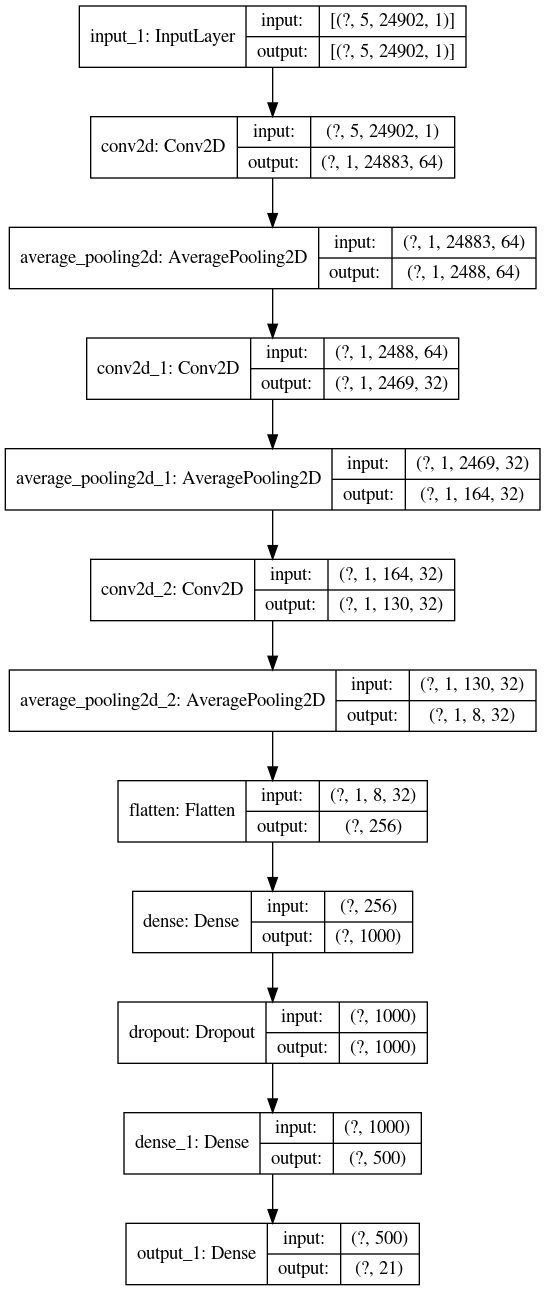

In [13]:
model = TERL()
# summarize layers
print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
one_hot_labels_train = tf.keras.utils.to_categorical(Y_train, num_classes=21)
one_hot_labels_validation = tf.keras.utils.to_categorical(Y_dev, num_classes=21)
one_hot_labels_test = tf.keras.utils.to_categorical(Y_test, num_classes=21)

# Fit the model
epochs = 100
#history = model.fit(X_train, one_hot_labels_train, epochs=epochs, 
                      #batch_size=32,
                      #validation_data=(X_dev, one_hot_labels_validation),
                      #verbose=1)

train(model, X_train, one_hot_labels_train, X_dev, one_hot_labels_validation, X_test, one_hot_labels_test, 64, epochs, "TERL")
Final_Results_Test(log_Dir)

Epoch 1/100
505/505 [==============================] - 19s 38ms/step - loss: 1.5976 - accuracy: 0.4610 - val_loss: 1.0080 - val_accuracy: 0.6474
Epoch 2/100
505/505 [==============================] - 19s 37ms/step - loss: 0.8855 - accuracy: 0.7014 - val_loss: 0.7905 - val_accuracy: 0.7331
Epoch 3/100
505/505 [==============================] - 19s 37ms/step - loss: 0.7101 - accuracy: 0.7597 - val_loss: 0.6811 - val_accuracy: 0.7727
Epoch 4/100
505/505 [==============================] - 19s 37ms/step - loss: 0.5793 - accuracy: 0.8043 - val_loss: 0.5567 - val_accuracy: 0.8190
Epoch 5/100
505/505 [==============================] - 19s 37ms/step - loss: 0.4755 - accuracy: 0.8410 - val_loss: 0.4901 - val_accuracy: 0.8438
Epoch 6/100
505/505 [==============================] - 19s 37ms/step - loss: 0.4079 - accuracy: 0.8644 - val_loss: 0.4362 - val_accuracy: 0.8601
Epoch 7/100
505/505 [==============================] - 19s 37ms/step - loss: 0.3421 - accuracy: 0.8860 - val_loss: 0.3824 - val_ac

505/505 [==============================] - 19s 37ms/step - loss: 0.0347 - accuracy: 0.9896 - val_loss: 0.4050 - val_accuracy: 0.9252
Epoch 58/100
505/505 [==============================] - 19s 37ms/step - loss: 0.0285 - accuracy: 0.9909 - val_loss: 0.4218 - val_accuracy: 0.9272
Epoch 59/100
505/505 [==============================] - 20s 39ms/step - loss: 0.0284 - accuracy: 0.9910 - val_loss: 0.3664 - val_accuracy: 0.9334
Epoch 60/100
505/505 [==============================] - 22s 43ms/step - loss: 0.0307 - accuracy: 0.9907 - val_loss: 0.3971 - val_accuracy: 0.9242
Epoch 61/100
505/505 [==============================] - 19s 37ms/step - loss: 0.0303 - accuracy: 0.9906 - val_loss: 0.3857 - val_accuracy: 0.9371
Epoch 62/100
505/505 [==============================] - 19s 37ms/step - loss: 0.0218 - accuracy: 0.9935 - val_loss: 0.3802 - val_accuracy: 0.9386
Epoch 63/100
505/505 [==============================] - 19s 37ms/step - loss: 0.0319 - accuracy: 0.9903 - val_loss: 0.4268 - val_accuracy

Loss=0.3318 y Accuracy=0.9324

saved-model-031-0.9277.hdf5
Loss=0.3069 y Accuracy=0.9304

saved-model-032-0.9208.hdf5
Loss=0.3610 y Accuracy=0.9208

saved-model-033-0.9327.hdf5
Loss=0.3132 y Accuracy=0.9393

saved-model-034-0.9294.hdf5
Loss=0.3423 y Accuracy=0.9341

saved-model-035-0.9304.hdf5
Loss=0.3493 y Accuracy=0.9287

saved-model-036-0.9314.hdf5
Loss=0.3313 y Accuracy=0.9359

saved-model-037-0.9302.hdf5
Loss=0.3372 y Accuracy=0.9344

saved-model-038-0.9322.hdf5
Loss=0.3194 y Accuracy=0.9426

saved-model-039-0.9332.hdf5
Loss=0.3031 y Accuracy=0.9388

saved-model-040-0.9223.hdf5
Loss=0.3751 y Accuracy=0.9354

saved-model-041-0.9280.hdf5
Loss=0.3666 y Accuracy=0.9354

saved-model-042-0.9208.hdf5
Loss=0.3937 y Accuracy=0.9307

saved-model-043-0.9265.hdf5
Loss=0.3535 y Accuracy=0.9349

saved-model-044-0.9240.hdf5
Loss=0.3837 y Accuracy=0.9327

saved-model-045-0.9289.hdf5
Loss=0.3363 y Accuracy=0.9396

saved-model-046-0.9292.hdf5
Loss=0.3751 y Accuracy=0.9364

saved-model-047-0.9235.hd

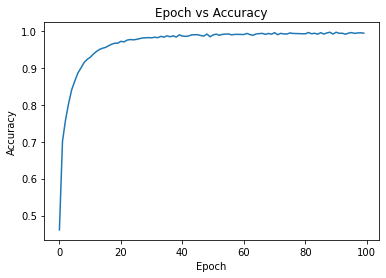

Test Accuracy 0.9485021233558655, Época:87

Test Accuracy 0.9465214014053345, Época:72

Test Accuracy 0.9457786679267883, Época:83

Test Accuracy 0.9457786679267883, Época:89

Test Accuracy 0.9457786679267883, Época:95


Train Accuracy 0.9966885447502136, Época:91

Train Accuracy 0.9966576099395752, Época:89

Train Accuracy 0.9959457516670227, Época:82

Train Accuracy 0.9957600831985474, Época:96

Train Accuracy 0.9955434799194336, Época:71


Validation Accuracy 0.9450358748435974, Época:87

Validation Accuracy 0.9433028101921082, Época:86

Validation Accuracy 0.9433028101921082, Época:96

Validation Accuracy 0.9413220882415771, Época:89

Validation Accuracy 0.9400841593742371, Época:90



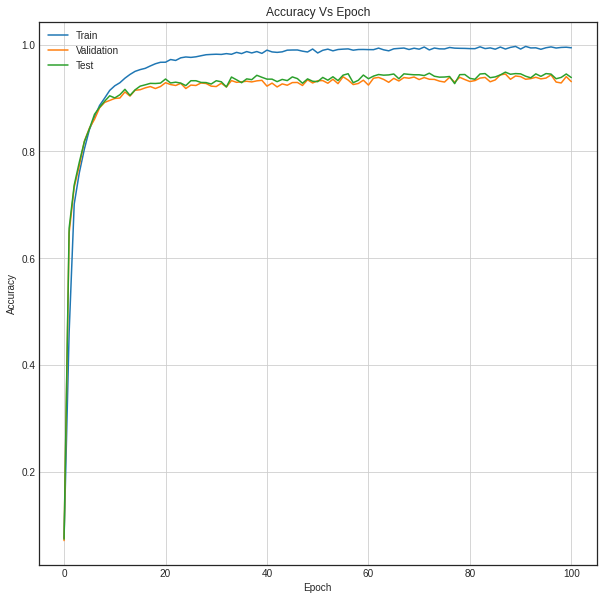

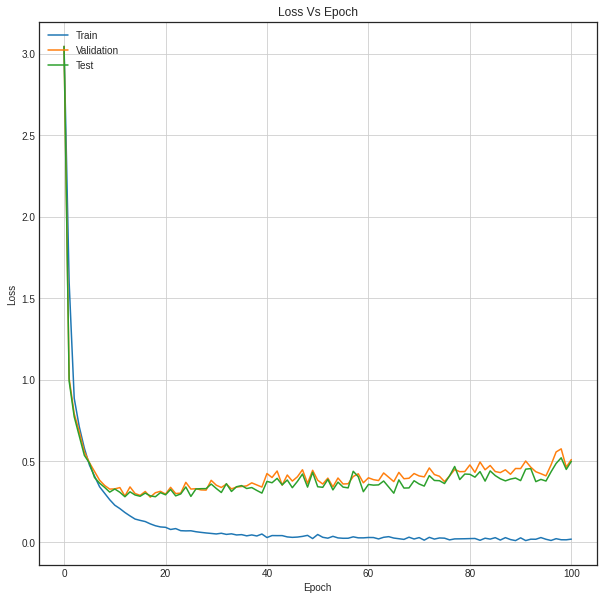

In [16]:
# plot metrics
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.show()

#GRÁFICOS DE LAS TRES CURVAS TRAIN TEST Y VALIDACIÓN
graphics(history, AccTest, LossTest, log_Dir, model_Name, lossTEST, lossTRAIN, lossVALID, accuracyTEST, accuracyTRAIN, accuracyVALID)


Baseline Error train: 0.24%
Baseline Error dev: 6.93%
Baseline Error test: 6.16%
Accuracy: 0.9976169844020797
F1 score: 0.9976175863829009
Recall: 0.9976169844020797
Precision: 0.997627083347573

 clasification report:
               precision    recall  f1-score   support

         1.0       1.00      1.00      1.00      4612
         3.0       0.99      1.00      1.00       681
         4.0       0.99      1.00      1.00       568
         8.0       0.98      0.98      0.98        45
         9.0       1.00      1.00      1.00      1948
        12.0       0.99      1.00      0.99      2809
        13.0       1.00      1.00      1.00      1861
        14.0       1.00      0.99      1.00      1193
        16.0       1.00      0.97      0.98       220
        17.0       1.00      1.00      1.00      2463
        18.0       0.99      1.00      1.00      4504
        19.0       1.00      1.00      1.00      2026
        20.0       1.00      1.00      1.00      9382

    accuracy          

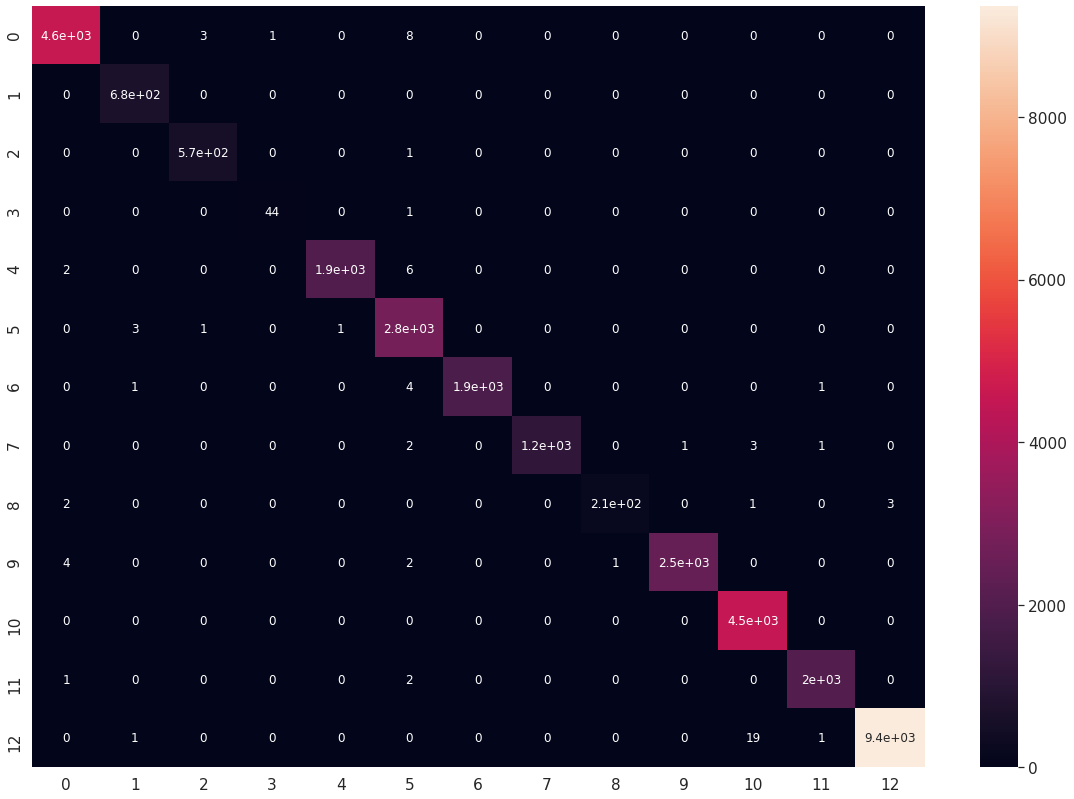

Accuracy: 0.9306759098786829
F1 score: 0.9304105209333544
Recall: 0.9306759098786829
Precision: 0.9320358127652918

 clasification report:
               precision    recall  f1-score   support

         1.0       0.96      0.96      0.96       600
         3.0       0.82      0.91      0.87        81
         4.0       0.83      0.90      0.86        70
         8.0       0.40      0.29      0.33         7
         9.0       0.93      0.88      0.90       256
        12.0       0.83      0.90      0.86       351
        13.0       0.96      0.92      0.94       249
        14.0       0.92      0.79      0.85       137
        16.0       0.82      0.52      0.64        27
        17.0       0.93      0.95      0.94       317
        18.0       0.90      0.97      0.93       542
        19.0       0.92      0.90      0.91       229
        20.0       0.98      0.96      0.97      1173

    accuracy                           0.93      4039
   macro avg       0.86      0.83      0.84     

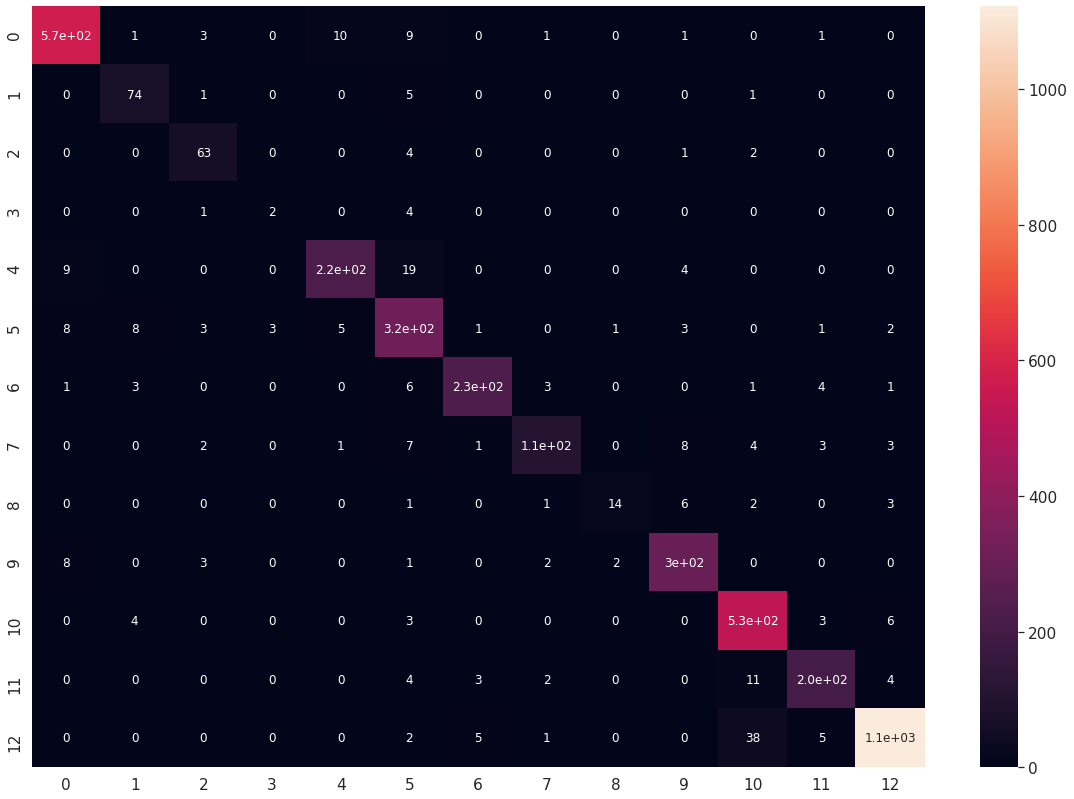

Accuracy: 0.9383510769992572
F1 score: 0.9385225048650028
Recall: 0.9383510769992572
Precision: 0.9406663376703261

 clasification report:
               precision    recall  f1-score   support

         1.0       0.97      0.96      0.96       570
         3.0       0.82      0.91      0.86        76
         4.0       0.86      0.95      0.90        87
         8.0       0.50      0.40      0.44         5
         9.0       0.97      0.90      0.93       250
        12.0       0.84      0.92      0.88       340
        13.0       0.95      0.91      0.93       216
        14.0       0.94      0.90      0.92       146
        16.0       0.93      0.64      0.76        39
        17.0       0.95      0.96      0.95       321
        18.0       0.89      0.97      0.93       535
        19.0       0.94      0.89      0.91       239
        20.0       0.98      0.95      0.97      1215

    accuracy                           0.94      4039
   macro avg       0.89      0.87      0.87     

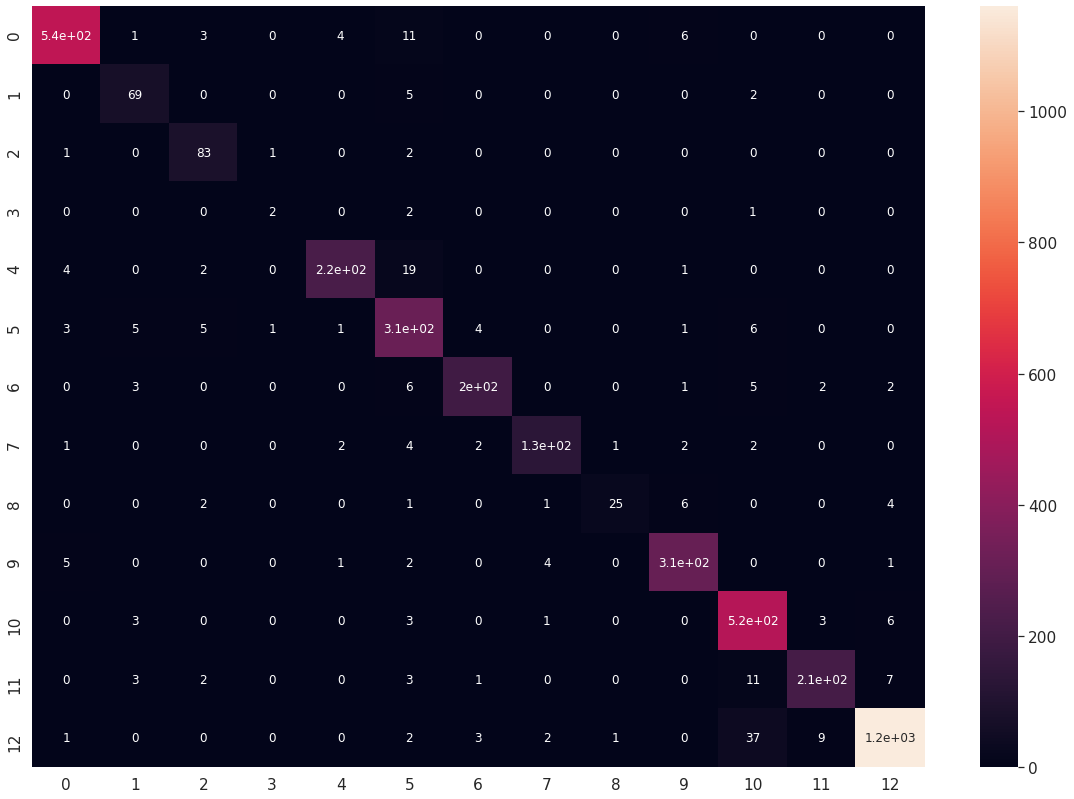

In [17]:
scores = model.evaluate(X_train, one_hot_labels_train, verbose=0)
print("Baseline Error train: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_dev, one_hot_labels_validation, verbose=0)
print("Baseline Error dev: %.2f%%" % (100-scores[1]*100))

scores = model.evaluate(X_test, one_hot_labels_test, verbose=0)
print("Baseline Error test: %.2f%%" % (100-scores[1]*100))

predictions = model.predict(X_train)

metrics(Y_train, [argmax(x) for x in predictions])

predictions = model.predict(X_dev)

metrics(Y_dev, [argmax(x) for x in predictions])

predictions = model.predict(X_test)

metrics(Y_test, [argmax(x) for x in predictions])